### Доверительные Интервалы для оценки среднего
Часто нам **недостаточно просто построить точечную оценку** среднего по выборке, — выборочное среднее, — а нам хочется понять, в каких диапазонах, вообще говоря, это среднее может изменяться. Именно для этого используют доверительные интервалы для оценки среднего

In [97]:
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import cross_val_score, train_test_split 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Генерация Данных

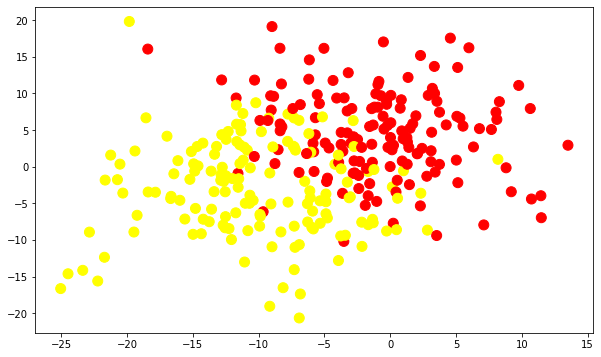

In [98]:
# Генерируем Данные
points = datasets.make_blobs(n_samples = 300, centers = 2, cluster_std = 6, random_state = 1)

# Визуализируем
plt.figure(figsize = (10, 6))
plt.scatter(list(map(lambda x: x[0], points[0])),
            list(map(lambda x: x[1], points[0])),
            c = points[1],
            cmap = 'autumn',
            s = 100);

### Сравнение Линейных Моделей
Решаем задачу бинарной классификации. При этом на этом наборе данных мы обучим две линейные модели и будем сравнивать их качество

### Точечная Оценка


In [30]:
# Разбиваем Данные
x_train, x_test, y_train, y_test = train_test_split(points[0], points[1], test_size = 15, random_state = 1)

# Первая Модель 
ridge_model = linear_model.RidgeClassifier()
ridge_model.fit(x_train, y_train)

# Смотрим на качество
ridge_score = metrics.roc_auc_score(y_test, ridge_model.predict(x_test))
print(f'Ridge_model ROC-AUC: {ridge_score}')

# Вторая Модель 
sgd_model = linear_model.SGDClassifier(random_state = 0)
sgd_model.fit(x_train, y_train)

# Смотрим на качество
sgd_score = metrics.roc_auc_score(y_test, sgd_model.predict(x_test))
print(f'SGD_model ROC-AUC: {sgd_score}')

Ridge_model ROC-AUC: 0.8888888888888888
SGD_model ROC-AUC: 0.7777777777777778


### Оценка Выборочного Среднего 
Оценим теперь не точечные оценки моделей а их выборочные средние. Для этого обучим модель на 20 фолдах, получим 20 значений качества модели и усредним их (т.е. возьмем выборочное среднее)

In [32]:
ridge_score = cross_val_score(ridge_model, points[0], points[1], scoring = 'roc_auc', cv = 20)
sgd_score = cross_val_score(sgd_model, points[0], points[1], scoring = 'roc_auc', cv = 20)

### Точечная Оценка Выборочных Средних

In [38]:
print(f'cross_val_score_ridge_mean: {ridge_score.mean()} std: {ridge_score.std(ddof=1)}')
print(f'cross_val_score_sgd_mean: {sgd_score.mean()} std: {sgd_score.std(ddof=1)}')

cross_val_score_ridge_mean: 0.9366071428571427 std: 0.07130510946541911
cross_val_score_sgd_mean: 0.9348214285714287 std: 0.06380222319175506


### Интервальная Оценка
Посмотрим в каком диапозоне изменяется среднее. Для получения интервальной оценки будем использовать `z интервал и t интервал`

In [41]:
# Для использования z и t интевалов импортируем
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic

# Наши оценки среднего
ridge_mean = ridge_score.mean()
sgd_mean = sgd_score.mean()

**Z - интервал**

Допустим, нам откуда-то известно, что дисперсия auc_scores $\sigma^2=0.25$. Построим доверительные интервалы для средних вида $$\bar{X}_n \pm z_{1-\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$$

In [47]:
print('Ridge Model Mean AUC With 95% Confidence Interval: ', _zconfint_generic(ridge_mean, np.sqrt(0.25/len(ridge_score)), 0.05, 'two-sided'))
print('SGD Model Mean AUC With 95% Confidence Interval: ', _zconfint_generic(sgd_mean, np.sqrt(0.25/len(sgd_score)), 0.05, 'two-sided'))

Ridge Model Mean AUC With 95% Confidence Interval:  (0.7174765077129974, 1.155737778001288)
SGD Model Mean AUC With 95% Confidence Interval:  (0.7156907934272834, 1.153952063715574)


Можем заметить что ДИ для Ridge Model находится правее, чем ДИ SGD Model. Это хорошо, так как подтверждает, что качество Ridge чуточку лучше

**T - интервал**

Вместо гипотетической теоретической дисперсии $\sigma^2$, которую мы на самом деле в данном случае не знаем, используем выборочные дисперсии, и построим доверительные интервалы вида $$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [49]:
# Определим std/sqrt(n)
ridge_mean_std = ridge_score.std(ddof=1)/np.sqrt(len(ridge_score))
sgd_mean_std = sgd_score.std(ddof=1)/np.sqrt(len(sgd_score))

print('Ridge Model Mean AUC With 95% Confidence Interval: ', _tconfint_generic(ridge_mean, ridge_mean_std, len(ridge_score) - 1, 0.05, 'two-sided'))
print('SGD Model Mean AUC With 95% Confidence Interval: ', _tconfint_generic(sgd_mean, sgd_mean_std, len(sgd_score) - 1, 0.05, 'two-sided'))

Ridge Model Mean AUC With 95% Confidence Interval:  (0.903235324375978, 0.9699789613383075)
SGD Model Mean AUC With 95% Confidence Interval:  (0.9049610689560689, 0.9646817881867885)


Также можно заметить что Ridge работает чуть лучше, ДИ стал уже, т.к. мы используем не случайную дисперсию

### Задание из теста
Для 61 большого города в Англии и Уэльсе известны средняя годовая смертность на 100000 населения (по данным 1958–1964) и концентрация кальция в питьевой воде (в частях на миллион). Чем выше концентрация кальция, тем жёстче вода. Города дополнительно поделены на северные и южные.

Постройте 95% доверительный интервал для средней годовой смертности в больших городах. Чему равна его нижняя граница? Округлите ответ до 4 знаков после десятичной точки. 

**Будьте осторожны при использовании метода std()!** Дело в том, что у объекта ```numpy``` он по умолчанию вычисляется как смещенная оценка, а у объектов ```pandas``` как несмещенная (нужна несмещенная)

Чтобы не думать всё время о том, правильно ли вычисляется в вашем случае ```std()```, можно всегда использовать ```std(ddof=1)``` (ddof — difference in degrees of freedom), тогда нормировка всегда будет на ```n-1```.

In [99]:
# Открываем файл и создаем необходимые параметры для DataFrame
with open('water.txt','r') as file:
    data = file.readlines()
    columns = [column.strip('\n') for column in data[0].split('\t')]
    clean_rows = []
    for row in data[1:]:
        clean_row = [value.strip('\n') for value in row.split('\t')]
        clean_rows.append(clean_row)

In [100]:
# Создаем DataFrame
df = pd.DataFrame(clean_rows, columns = columns)

# Приведем типы 
df['mortality'] = df['mortality'].astype('int')
df['hardness'] = df['hardness'].astype('int')

In [106]:
# Посчитаем доверительный интервал (95%) для средней годовой смертности (признак mortality)
sample_mean = df['mortality'].mean() # выборочное среднее
sample_std = df['mortality'].std() # std с ипользованием ddof = 1

# Т.к. используем выборочную дисперсию, то применяем t - интервал
from statsmodels.stats.weightstats import _tconfint_generic
sample_std_mean = sample_std/np.sqrt(df.shape[0])
deg_of_fred = df.shape[0] - 1

# Интервал
t_conf_interval = _tconfint_generic(sample_mean, sample_std_mean, deg_of_fred, 0.05, 'two-sided')
print(f'95 % Confidence Interval (All Cities): {round(t_conf_interval[0], 4)} - {round(t_conf_interval[1], 4)}')

95 % Confidence Interval (All Cities): 1476.0833 - 1572.2117


На данных из предыдущего вопроса постройте 95% доверительный интервал для средней годовой смертности по всем южным городам. Чему равна его верхняя граница? Округлите ответ до 4 знаков после десятичной точки.

In [107]:
# 95% Доверительный Интервал для годовой смертности по всем южным городам
south_sample_mean = df[df['location'] == 'South']['mortality'].mean()
south_std = df[df['location'] == 'South']['mortality'].std()
south_n_samples = df[df['location'] == 'South']['mortality'].shape[0]

# Необходимы параметры для t - интервала 
south_std_mean = south_std/np.sqrt(south_n_samples)
deg_of_fred = south_n_samples - 1

# Интервал 
t_conf_interval = _tconfint_generic(south_sample_mean, south_std_mean, deg_of_fred, 0.05, 'two-sided')
print(f'95 % Confidence Interval (South Cities): {round(t_conf_interval[0], 4)} - {round(t_conf_interval[1], 4)}')

95 % Confidence Interval (South Cities): 1320.1517 - 1433.4636


На тех же данных постройте 95% доверительный интервал для средней годовой смертности по всем северным городам. Пересекается ли этот интервал с предыдущим? Как вы думаете, какой из этого можно сделать вывод? 

In [110]:
# 95% Доверительный Интервал для годовой смертности по всем северным городам
north_sample_mean = df[df['location'] == 'North']['mortality'].mean()
noth_std = df[df['location'] == 'North']['mortality'].std()
north_n_samples = df[df['location'] == 'North']['mortality'].shape[0]

# Необходимы параметры для t - интервала 
north_std_mean = noth_std/np.sqrt(north_n_samples)
deg_of_fred = north_n_samples - 1

# Интервал 
t_conf_interval = _tconfint_generic(north_sample_mean, north_std_mean, deg_of_fred, 0.05, 'two-sided')
print(f'95 % Confidence Interval (North Cities): {round(t_conf_interval[0], 4)} - {round(t_conf_interval[1], 4)}')

95 % Confidence Interval (North Cities): 1586.5605 - 1680.6395


ДИ не пересекаются, значит смертность между северными и южными городами отличается

Проведем теперь анализ для средней жёсткости воды в северных и южных городах

In [111]:
# 95% Доверительный Интервал для средней жестесоти воды (южные города)
south_hardness_sample_mean = df[df['location'] == 'South']['hardness'].mean()
south_hardness_std = df[df['location'] == 'South']['hardness'].std()
south_n_samples = df[df['location'] == 'South']['hardness'].shape[0]

# Необходимы параметры для t - интервала 
south_hardness_std_mean = south_hardness_std/np.sqrt(south_n_samples)
deg_of_fred = south_n_samples - 1

# Интервал 
t_conf_interval = _tconfint_generic(south_hardness_sample_mean, south_hardness_std_mean, deg_of_fred, 0.05, 'two-sided')
print(f'95 % Confidence Interval (South Cities): {round(t_conf_interval[0], 4)} - {round(t_conf_interval[1], 4)}')

95 % Confidence Interval (North Cities): 53.4672 - 86.0713


In [112]:
# 95% Доверительный Интервал для средней жесткости воды (северные города)
north_hardness_sample_mean = df[df['location'] == 'North']['hardness'].mean()
north_hardness_std = df[df['location'] == 'North']['hardness'].std()
north_n_samples = df[df['location'] == 'North']['hardness'].shape[0]

# Необходимы параметры для t - интервала 
north_hardness_std_mean = north_hardness_std/np.sqrt(north_n_samples)
deg_of_fred = north_n_samples - 1

# Интервал 
t_conf_interval = _tconfint_generic(north_hardness_sample_mean, north_hardness_std_mean, deg_of_fred, 0.05, 'two-sided')
print(f'95 % Confidence Interval (North Cities): {round(t_conf_interval[0], 4)} - {round(t_conf_interval[1], 4)}')

95 % Confidence Interval (North Cities): 21.4225 - 39.3775
